In [1]:
from random import shuffle
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch import nn
import numpy as np
def plot_square(wcopy, **kwargs):
    ns = np.ceil(np.sqrt(wcopy.shape[0])).astype(int)
    s = np.zeros(ns**2)
    s[:wcopy.size] = wcopy
    s = s.reshape(ns,ns)
    plt.imshow(s, **kwargs)
# mms = MinMaxScaler()
def get_data(target_digit1=9, target_digit2=1):
    pca = PCA(n_components=4)

    mnist = fetch_openml('mnist_784')
    X_orig, y_orig = mnist["data"], mnist["target"]

    X_orig = np.clip(np.array(X_orig).astype(np.float32) / 255.0, 0.0, 1.0)
    y_orig = np.array(y_orig).astype(np.uint8)

    target_digit1_xdata = X_orig[y_orig == target_digit1]
    target_digit2_xdata = X_orig[y_orig == target_digit2]#[:300]
    target_digit1_ydata = y_orig[y_orig == target_digit1]
    target_digit2_ydata = y_orig[y_orig == target_digit2]#[:300]
    X = np.concatenate((target_digit1_xdata, target_digit2_xdata), axis=0)
    y = np.concatenate((target_digit1_ydata, target_digit2_ydata), axis=0)

    y = np.where(y == target_digit1, -1, 1)
    return X, y

# reduce the dimensions of X
# X = pca.fit_transform(X)

# # add on the bias
# X = np.concatenate([np.ones_like(X[:, :1]), X],axis=-1)
# plot_square(target_digit1_xdata[0], cmap=plt.get_cmap("gray"))

In [2]:
# plot_square(target_digit2_xdata[0], cmap=plt.get_cmap("gray"))

In [3]:
X, y = get_data(3, 8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# pca.fit(X_train)

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(8379, 784) (2793, 784) (2794, 784)
(8379,) (2793,) (2794,)


In [4]:
# # pca2 = PCA(n_components=2)
# # plotx = pca.fit_transform(X_train)
#
# formatter = plt.FuncFormatter(lambda i, *args: np.where(y_train[i] == 1, target_digit2, target_digit1))
# plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
# plt.colorbar(ticks=[0, 1], format=formatter)
# # plt.xlabel(iris.feature_names[x_index])
# # plt.ylabel(iris.feature_names[y_index])
# plt.show()

In [5]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
device = 'cpu'
X_train = torch.Tensor(X_train).to(device)
y_train = torch.Tensor(y_train).to(device)
X_test = torch.Tensor(X_test).to(device)
y_test = torch.Tensor(y_test).to(device)
X_val = torch.Tensor(X_val).to(device)
y_val = torch.Tensor(y_val).to(device)
# train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=1024)
# test_dl = TensorDataset(X_test, y_test)
# val_dl = TensorDataset(X_val, y_val)


100%|██████████| 10000/10000 [00:18<00:00, 529.94it/s, loss=0.323]


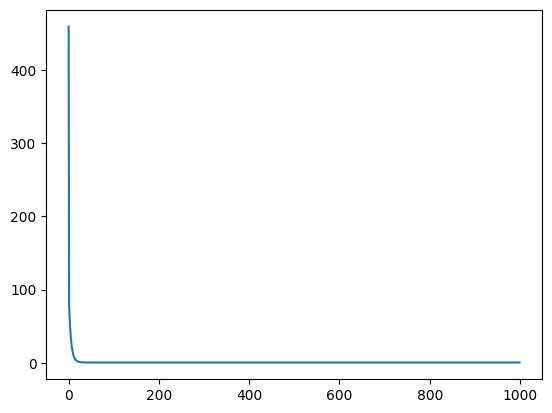

In [6]:
class LinearSVM(nn.Module):
    def __init__(self, dim, C=1.0, bias=True):
        super().__init__()
        self.dim = dim
        self.w = nn.Parameter(torch.rand(self.dim))
        self.C = C
        self.b = nn.Parameter(torch.rand(1)) if bias else None

    def forward(self, X):                             # scores s = w^T x + b
        s = X @ self.w
        return s + self.b if self.b is not None else s

    def svm_loss(self, X, y, C=None, regularize_bias=False):
        C = C or self.C
        y = y.to(self.w.dtype)                          # y in {-1,+1}, float
        s = self(X)
        hinge = torch.clamp(1.0 - y * s, min=0.0)
        data_term = hinge.pow(2).mean()

        reg = 0.5 * (self.w @ self.w)

        if regularize_bias and (self.b is not None):
            reg = reg + 0.5 * (self.b * self.b)

        return reg + C * data_term

def train_model(Xtr, ytr, Xva, yva, lr=1e-2, num_epochs=2000, model=None):

    dim = Xtr.size(1)
    if model is None:
        model = LinearSVM(dim, C=1.0).to(device)

    opt = torch.optim.SGD(model.parameters(), lr=lr)
    sb = tqdm(range(num_epochs))
    tl = []

    for epoch in sb:
        # for Xb, yb in train_dl:
        Xb, yb = Xtr, ytr
        loss = model.svm_loss(Xb, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()

        if epoch % 10 == 0:
            with torch.no_grad():
                loss = model.svm_loss(Xva, yva)
                tl.append(loss.item())
                sb.set_postfix(loss=tl[-1])
    return model, tl

mdl, tl = train_model(X_train, y_train, X_val, y_val, num_epochs=10000)
from matplotlib import pyplot as plt
plt.plot(np.array(tl))
plt.show()

In [7]:
from sklearn import metrics
y_test_np = y_test.detach().numpy() > 0
y_pred_np = (X_test @ mdl.w).detach().numpy() > 0
print(metrics.accuracy_score(y_test_np, y_pred_np))
print(metrics.precision_score(y_test_np, y_pred_np))
print(metrics.recall_score(y_test_np, y_pred_np))
metrics.confusion_matrix(y_test_np, y_pred_np)

0.9294665234514858
0.8800521512385919
0.9904622157006603


array([[1246,  184],
       [  13, 1350]])

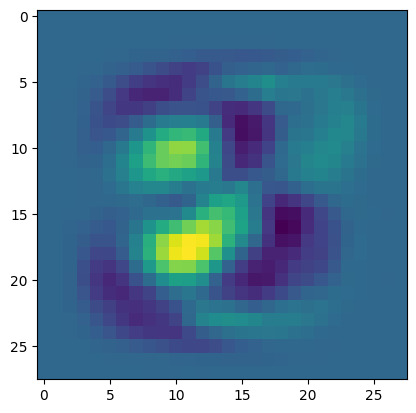

In [8]:

plot_square(np.copy(mdl.w.detach().numpy()))

# Now to break it

In [9]:
for param in mdl.parameters():
    param.requires_grad = False


In [10]:
# num_epochs = 10000
# l2_reg = 0.2
#
# perturbation = torch.rand(X_train.size(1)) * 0.1
# perturbation.requires_grad = True
#
# opt = torch.optim.SGD([perturbation], lr=1e-1)
#
# Xb = X_train[-1:, :]
# yb = y_train[-1:]
# yb_pred_new = mdl(Xb).sign().detach().numpy()
#
#
# sb = tqdm(range(num_epochs))
# tl = []
# for epoch in sb:
#     new_Xb = torch.clamp(Xb + perturbation, 0.0, 1.0)
#     new_yb = yb * -1
#     loss = mdl.svm_loss(new_Xb, new_yb)
#
#     l2_loss = perturbation.norm()
#     total_loss = loss + l2_reg * l2_loss
#     opt.zero_grad()
#     total_loss.backward()
#     opt.step()
#
#     if epoch % 10 == 0:
#         with torch.no_grad():
#             pred = mdl(new_Xb).sign().detach().numpy()
#             # print(pred != yb_pred_new, np.sum(pred != yb_pred_new))
#             # break
#             if np.sum(pred != yb_pred_new) >= len(pred):
#                 print("Finished!")
#                 break
#             loss = mdl.svm_loss(Xb + perturbation, yb)
#             tl.append(loss.item())
#             sb.set_postfix(loss=tl[-1])


  0%|          | 40/10000 [00:00<00:04, 2363.52it/s, loss=0.882]

Finished!


In [10]:
# plot_square(Xb[0].detach().numpy())

In [11]:
# plot_square((Xb[0].detach().numpy() + perturbation.detach().numpy()))


In [12]:
# plot_square((perturbation.detach().numpy()))


# Now to break CAL

In [19]:
# for param in mdl.parameters():
#     param.requires_grad = True

tensor([1.])

In [22]:
X_seed = X_test[2:3, ]
y_seed = y_test[2:3]

seed_target = y_seed.item()
print(seed_target)

X_found = X_train
y_real = torch.clone(y_train)

num_cal_steps = 100

mdl = None
SIZE = 250
for iteration in range(num_cal_steps):
    print("Size {}".format(X_seed.size()[0]))
    y_found = torch.ones_like(y_real) * (-seed_target)
    X_combined = torch.cat([X_found, X_seed], dim=0)
    y_combined = torch.cat([y_found, y_seed], dim=0)

    mdl, tl = train_model(X_combined, y_combined, X_val, y_val, num_epochs=1000, lr=1e-2, model=mdl)
    v, top_n_indices = torch.topk((X_found @ mdl.w), SIZE, largest=seed_target == 1.0)


    maskn = torch.zeros(X_found.size()[0], dtype=torch.bool)

    # Set the positions of the top items to True
    maskn[top_n_indices] = True
    # ampersand it with whether it's in the target env or not
    mask = torch.logical_and(maskn, y_real == seed_target)

    summask = torch.sum(mask).item()
    print(summask/SIZE)
    if summask/SIZE < 1e-2:
        break
    # Select the items that are NOT in the top n by inverting the mask
    X_seed = torch.cat([X_found[mask], X_seed], dim=0)
    y_seed = torch.cat([y_real[mask], y_seed], dim=0)

    X_found = X_found[~maskn]
    y_real = y_real[~maskn]

1.0
Size 1


100%|██████████| 1000/1000 [00:01<00:00, 505.15it/s, loss=2.17]


0.956
Size 240


100%|██████████| 1000/1000 [00:01<00:00, 522.92it/s, loss=1.82]


0.984
Size 486


100%|██████████| 1000/1000 [00:01<00:00, 554.36it/s, loss=1.71]


0.96
Size 726


100%|██████████| 1000/1000 [00:01<00:00, 520.04it/s, loss=1.63]


0.948
Size 963


100%|██████████| 1000/1000 [00:01<00:00, 531.97it/s, loss=1.53]


0.936
Size 1197


100%|██████████| 1000/1000 [00:01<00:00, 526.80it/s, loss=1.43]


0.9
Size 1422


100%|██████████| 1000/1000 [00:01<00:00, 524.29it/s, loss=1.31]


0.844
Size 1633


100%|██████████| 1000/1000 [00:01<00:00, 535.99it/s, loss=1.2]


0.884
Size 1854


100%|██████████| 1000/1000 [00:01<00:00, 534.08it/s, loss=1.09]


0.884
Size 2075


100%|██████████| 1000/1000 [00:01<00:00, 523.72it/s, loss=0.972]


0.856
Size 2289


100%|██████████| 1000/1000 [00:01<00:00, 606.34it/s, loss=0.864]


0.86
Size 2504


100%|██████████| 1000/1000 [00:01<00:00, 607.05it/s, loss=0.762]


0.876
Size 2723


100%|██████████| 1000/1000 [00:01<00:00, 614.70it/s, loss=0.666]


0.84
Size 2933


100%|██████████| 1000/1000 [00:01<00:00, 619.37it/s, loss=0.581]


0.844
Size 3144


100%|██████████| 1000/1000 [00:01<00:00, 623.76it/s, loss=0.506]


0.828
Size 3351


100%|██████████| 1000/1000 [00:01<00:00, 630.91it/s, loss=0.442]


0.772
Size 3544


100%|██████████| 1000/1000 [00:01<00:00, 612.22it/s, loss=0.393]


0.764
Size 3735


100%|██████████| 1000/1000 [00:01<00:00, 638.45it/s, loss=0.359]


0.64
Size 3895


100%|██████████| 1000/1000 [00:01<00:00, 639.06it/s, loss=0.344]


0.436
Size 4004


100%|██████████| 1000/1000 [00:01<00:00, 663.18it/s, loss=0.348]


0.172
Size 4047


100%|██████████| 1000/1000 [00:01<00:00, 676.10it/s, loss=0.36]


0.048
Size 4059


100%|██████████| 1000/1000 [00:01<00:00, 693.57it/s, loss=0.376]


0.036
Size 4068


100%|██████████| 1000/1000 [00:01<00:00, 718.17it/s, loss=0.394]


0.016
Size 4072


100%|██████████| 1000/1000 [00:01<00:00, 738.12it/s, loss=0.416]


0.012
Size 4075


100%|██████████| 1000/1000 [00:01<00:00, 773.71it/s, loss=0.442]

0.0


In [78]:
mdl, tl = train_model(X_combined, y_combined, X_val, y_val, num_epochs=100000, lr=2e-1)
v, top_n_indices = torch.topk((X_train @ mdl.w), 10, largest=True)


mask = torch.zeros(X_train.size()[0], dtype=torch.bool)

# Set the positions of the top items to True
mask[top_n_indices] = True
# ampersand it with whether it's in the target env or not
mask = torch.logical_and(mask, y_train == seed_target)

# Select the items that are NOT in the top n by inverting the mask
X_selected = X_train[mask]
y_selected = y_train[mask]

X_rest = X_train[~mask]
y_rest = y_train[~mask]

100%|██████████| 10000/10000 [00:24<00:00, 415.27it/s, loss=25] 


In [68]:
import pandas as pd
y_score = (X_train @ mdl.w).detach().numpy().reshape(-1,1)
df = pd.DataFrame({'y_actual': y_train.detach().numpy(),'scores': y_score.reshape(-1)})
df.sort_values('scores',ascending=True)


,y_actual,scores
3950,-1.0,0.008209
6512,-1.0,0.008850
5871,1.0,0.011345
6824,1.0,0.011428
6023,1.0,0.011711
...,...,...
5142,1.0,0.120737
2246,1.0,0.121957
5722,1.0,0.122500
1115,1.0,0.123171


In [69]:
from sklearn import metrics


y_test_np = y_test.detach().numpy() == 1
y_pred_np = (X_test @ mdl.w).detach().numpy() < 0
print(metrics.accuracy_score(y_test_np, y_pred_np))
print(metrics.precision_score(y_test_np, y_pred_np))
print(metrics.recall_score(y_test_np, y_pred_np))
metrics.confusion_matrix(y_test_np, y_pred_np)

0.4620829120323559
0.0
0.0


/Users/christopear/PycharmProjects/tarpoison/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


array([[1371,    0],
       [1596,    0]])

array([0., 0., 0., ..., 0., 0., 0.])

ValueError: Classification metrics can't handle a mix of binary and continuous targets

/var/folders/sh/x7gvx6517mx2_19qkh1b6y0w0000gn/T/ipykernel_7270/824274905.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


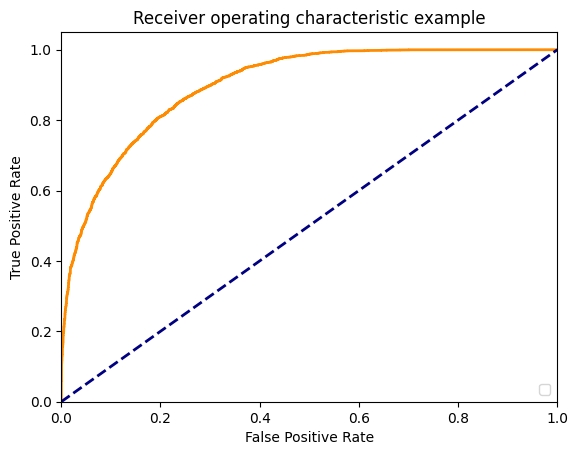

In [156]:
from sklearn.metrics import roc_curve, auc

y_train2 = 1 - (y_train + 1) / 2
# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_train2, y_score)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [22]:
from sklearn import metrics
y_pred = (X_test @ mdl.w > 0) * 1.0
y_test_np = (y_test.detach().numpy() + 1.0)/2
y_pred_np = y_pred.detach().numpy()
print(metrics.accuracy_score(y_test_np, y_pred_np))
print(metrics.precision_score(y_test_np, y_pred_np))
print(metrics.recall_score(y_test_np, y_pred_np))
metrics.confusion_matrix(y_test_np, y_pred_np)

0.03425076452599388
0.03425076452599388
1.0


array([[   0, 1579],
       [   0,   56]])

# Now to break training


In [33]:
for param in model.parameters():
    param.requires_grad = True

C = 1.0

lr = 1e-2
num_epochs = 10

NUM_POISON_POINTS = 100

Xp = torch.rand((NUM_POISON_POINTS, X_train.size(1)))
yp = torch.Tensor([1] * (NUM_POISON_POINTS//2) + [-1] * (NUM_POISON_POINTS//2))
Xp.requires_grad = True


oldw = np.copy(model.w.detach().numpy())
oldb = np.copy(model.b.detach().numpy())
# dim = X_train.size(1)
# model = LinearSVM(dim, C=1.0).to(device)
optmodel = torch.optim.SGD(model.parameters(), lr=1e-4)
optpoison = torch.optim.SGD([Xp], lr=1e-1)

num_epochs = 500
sb = tqdm(range(num_epochs))
tl = []

for epoch in sb:
    Xb = torch.cat([X_train, Xp],dim=0)
    yb = torch.cat([y_train, yp], dim=0)

    # train the model stage
    loss = model.svm_loss(Xb, yb)
    optmodel.zero_grad()
    loss.backward()
    optmodel.step()

    # train the poison stage
    # new_Xb = torch.clamp(Xb, 0.0, 1.0)
    loss = -model.svm_loss(Xb, yb)
    optpoison.zero_grad()
    loss.backward()
    optpoison.step()
    with torch.no_grad():
        Xp = torch.clamp(Xp, 0.0, 1.0)

    if epoch % 10 == 0:
        with torch.no_grad():
            loss = model.svm_loss(X_val, y_val)
            tl.append(loss.item())
            sb.set_postfix(loss=tl[-1])

neww = model.w.detach().numpy()
newb = model.b.detach().numpy()
print(neww - oldw)

100%|██████████| 500/500 [00:02<00:00, 172.27it/s, loss=0.323]

[-4.16868279e-05  4.42332748e-06 -4.04657912e-05 -1.33730064e-05
 -7.26606231e-06  8.88902105e-06  1.64149096e-05 -4.27795458e-05
 -1.33696740e-05  1.38467658e-06 -4.56342968e-06  1.24682892e-05
  1.38444302e-05 -3.12023849e-06  3.89931374e-05  8.93797551e-06
  4.96213761e-05 -1.08397217e-06  1.08508830e-05 -3.23262211e-05
 -1.86180932e-05 -1.53441142e-05 -2.92278128e-05 -2.66719435e-05
 -1.41900591e-05 -4.80965100e-05  2.14744068e-06  1.81049527e-05
 -3.73163784e-05  4.48439096e-06 -4.31298395e-06  1.00063335e-05
 -1.14215072e-06 -8.27599506e-05 -9.79057222e-06 -1.23997916e-06
  3.32828495e-06 -1.76671019e-05  1.48961699e-05  6.57064957e-05
  5.52639176e-05 -3.84399318e-05  2.61337846e-06  1.85758399e-05
 -3.93016671e-05  2.52220198e-05 -4.39053110e-06  2.15528416e-05
 -1.53825313e-05 -2.73757032e-05 -5.53559730e-05 -6.38100319e-05
 -1.24554645e-05  5.79426560e-05 -3.87156069e-05  3.70728085e-05
  3.01110049e-05 -1.09267596e-04  1.54998997e-05 -4.42716264e-05
 -8.02513387e-06 -2.84703

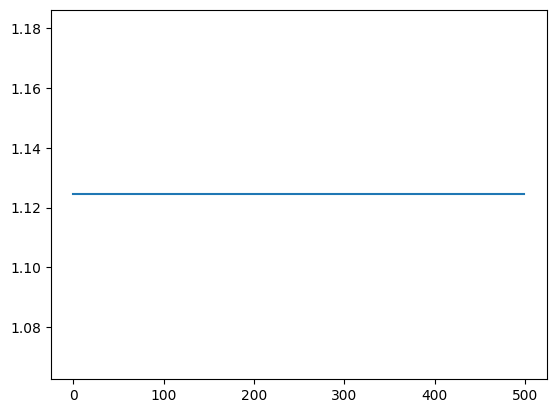

In [32]:
tlnp = np.array(tl)
# tlnpdiff = tlnp[1:] - tlnp[:-1]
plt.plot(tlnp)

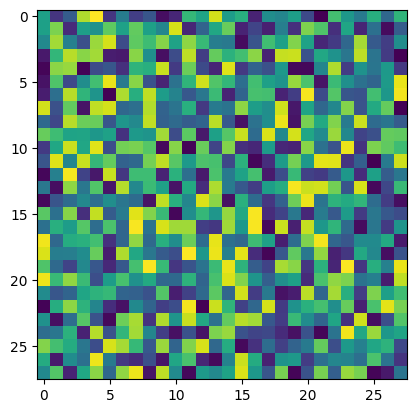

In [31]:
plt.imshow(Xp[1:2].detach().numpy().reshape((28,28)))

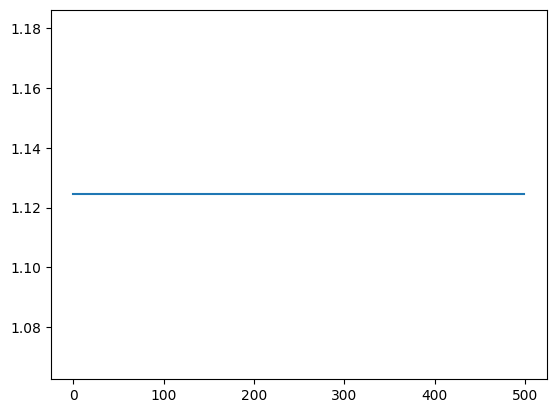

In [22]:
plt.plot(tl)

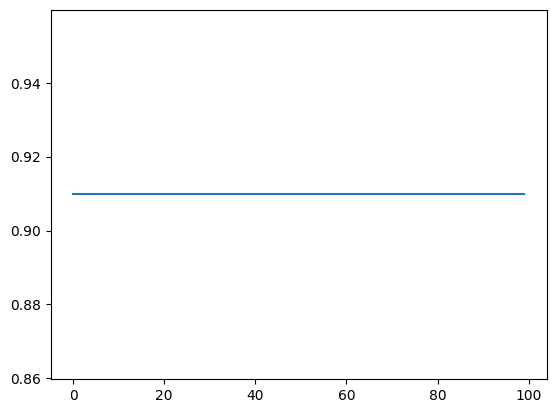